Paso 1: Preparación de Datos y Selección Aleatoria de Experimentos

## Implementacion de Proceso Gaussiano

### Carga de datos

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos (ajusta la ruta al archivo si es necesario)
archivo_datos = '/Users/ronaldpoint/Downloads/GP_Inventarios/exportados.csv'
data = pd.read_csv(archivo_datos, delimiter=';')
data
# Mostrar una muestra de los datos
data.sample(5)


: 

/var/folders/pr/3_ymb44114ldz2qpgfkjb9y80000gn/T/ipykernel_16479/1284016574.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  producto_daily_data = producto_data.groupby('Fecha').sum()


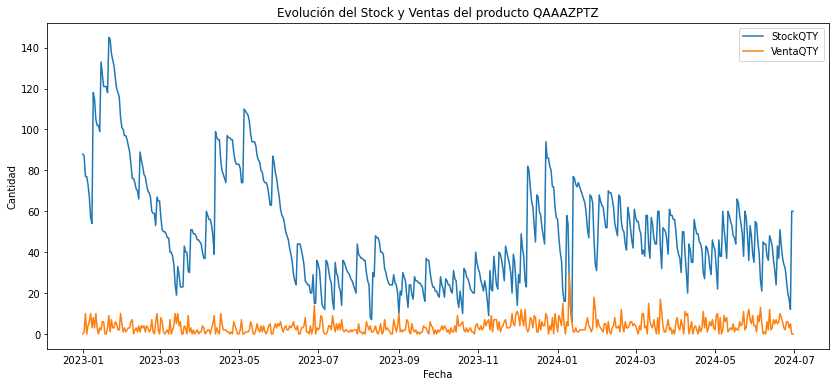

In [3]:
# Asegurarse de que la columna Fecha es de tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Filtrar los datos por un producto específico (Material)
# producto_codigo = 'QAAAZKZK'  # Reemplaza con el código del producto que quieres analizar
producto_codigo = 'QAAAZPTZ'  # Reemplaza con el código del producto que quieres analizar

producto_data = data[data['Material'] == producto_codigo]

# Agrupar por fecha para obtener el total diario
producto_daily_data = producto_data.groupby('Fecha').sum()

# Plot de StockQTY y VentaQTY a lo largo del tiempo para este producto
plt.figure(figsize=(14, 6))
plt.plot(producto_daily_data.index, producto_daily_data['StockQTY'], label='StockQTY')
plt.plot(producto_daily_data.index, producto_daily_data['VentaQTY'], label='VentaQTY')
plt.title(f'Evolución del Stock y Ventas del producto {producto_codigo}')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.show()


### Paso 2: Preparar la función para ajustar el modelo Gaussiano

/Users/ronaldpoint/opt/anaconda3/envs/data_analysis/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


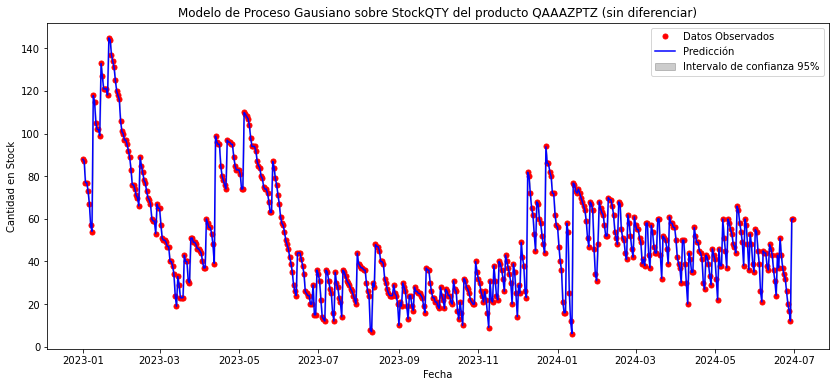

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np
import matplotlib.pyplot as plt

# Selección de los datos de entrenamiento y objetivo sobre la serie original
X = np.arange(len(producto_daily_data)).reshape(-1, 1)  # Convertimos fechas en números secuenciales
y = producto_daily_data['StockQTY'].values  # Variable objetivo

# Definir el kernel: el núcleo RBF con un multiplicador constante
kernel = C(1.0, (1e-4, 1e1)) * RBF(10, (1e-2, 1e2))

# Crear y entrenar el modelo
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

gp.fit(X, y)

# Predicción en el mismo rango de fechas
y_pred, sigma = gp.predict(X, return_std=True)

# Visualización del ajuste con incertidumbre
plt.figure(figsize=(14, 6))
plt.plot(producto_daily_data.index, y, 'r.', markersize=10, label='Datos Observados')
plt.plot(producto_daily_data.index, y_pred, 'b-', label='Predicción')
plt.fill_between(producto_daily_data.index, y_pred - 1.96*sigma, y_pred + 1.96*sigma, 
                 alpha=0.2, color='k', label='Intervalo de confianza 95%')
plt.title(f'Modelo de Proceso Gausiano sobre StockQTY del producto {producto_codigo} (sin diferenciar)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad en Stock')
plt.legend()
plt.show()


In [6]:
# Mostrar la cantidad de datos utilizados en el modelo
n_datos = len(producto_daily_data)
print(f"Cantidad de datos utilizados en el modelo: {n_datos}")


Cantidad de datos utilizados en el modelo: 497


## Código Modificado para Seleccionar Muestra Aleatoria

In [ ]:
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
import numpy as np
import matplotlib.pyplot as plt

# Definir una función para probar diferentes kernels y cantidades de datos seleccionados aleatoriamente
def test_gp_with_random_samples(producto_daily_data, kernel, n_points):
    # Seleccionar aleatoriamente n_points del conjunto de datos
    total_points = len(producto_daily_data)
    random_indices = random.sample(range(total_points), n_points)
    random_indices.sort()  # Ordenar los índices para que las fechas estén en orden cronológico
    
    # Crear los conjuntos de datos de entrenamiento aleatorios
    X = np.array(random_indices).reshape(-1, 1)
    y = producto_daily_data['StockQTY'].values[random_indices]

    # Crear y entrenar el modelo
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    gp.fit(X, y)

    # Predicción en el mismo rango de fechas
    y_pred, sigma = gp.predict(X, return_std=True)

    # Visualización del ajuste con incertidumbre
    plt.figure(figsize=(14, 6))
    plt.plot(producto_daily_data.index[random_indices], y, 'r.', markersize=10, label='Datos Observados')
    plt.plot(producto_daily_data.index[random_indices], y_pred, 'b-', label='Predicción')
    plt.fill_between(producto_daily_data.index[random_indices], y_pred - 1.96*sigma, y_pred + 1.96*sigma, 
                     alpha=0.2, color='k', label='Intervalo de confianza 95%')
    plt.title(f'GP con {kernel} y {n_points} puntos (selección aleatoria)')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad en Stock')
    plt.legend()
    plt.show()

    # Imprimir los parámetros del kernel optimizado
    print(f'Kernel después de la optimización: {gp.kernel_}')

# Definir los kernels a probar
kernels = [
    # RBF(length_scale=1.0),  # Kernel RBF
    # Matern(length_scale=1.0, nu=1.5),  # Kernel Matern
    # RationalQuadratic(length_scale=1.0, alpha=0.1),  # Kernel RationalQuadratic
    ExpSineSquared(length_scale=1.0, periodicity=7.0),  # Kernel periódico (ExpSineSquared)
    # DotProduct()  # Kernel DotProduct
]

# Probar cada kernel con una cantidad específica de puntos seleccionados aleatoriamente
for kernel in kernels:
    test_gp_with_random_samples(producto_daily_data, kernel, n_points=150)  # Prueba con 50 puntos aleatorios
    test_gp_with_random_samples(producto_daily_data, kernel, n_points=479)  # Prueba con todos los puntos (aleatorios no importa en este caso)


: 

## Prediccion de nuevos dias 

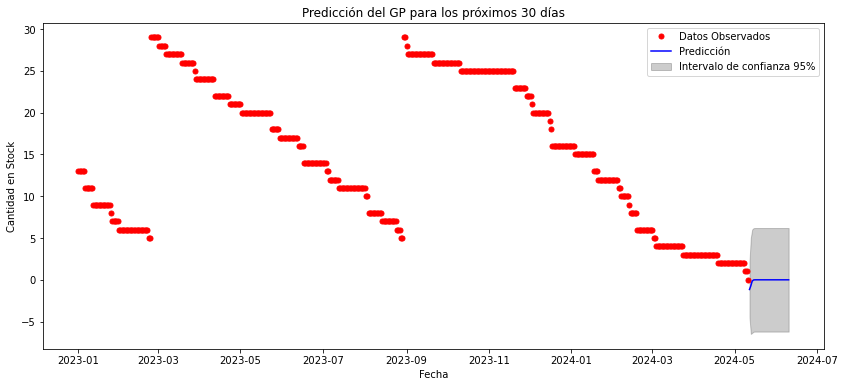

Predicción para el 2024-05-12: -1.15 con incertidumbre de 1.71
Predicción para el 2024-05-13: -0.72 con incertidumbre de 2.94
Predicción para el 2024-05-14: -0.16 con incertidumbre de 3.15
Predicción para el 2024-05-15: -0.02 con incertidumbre de 3.16
Predicción para el 2024-05-16: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-17: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-18: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-19: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-20: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-21: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-22: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-23: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-24: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-25: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-26: -0.00 con incertidumbre de 3.16
Predicción para el 2024-05-27: -0.00 con incertidumbre 

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que quieres predecir los próximos 30 días
n_dias_prediccion = 30

# Definir nuevos puntos de entrada para predicción
nuevos_dias = np.arange(len(producto_daily_data), len(producto_daily_data) + n_dias_prediccion).reshape(-1, 1)

# Asegurarse de que el modelo gp esté entrenado (si no lo está, asegúrate de ejecutar la parte de entrenamiento previamente)
# Hacer predicciones con el modelo entrenado
y_pred_nuevo, sigma_nuevo = gp.predict(nuevos_dias, return_std=True)

# Crear un rango de fechas que se extienda a los días predichos
fechas_prediccion = pd.date_range(producto_daily_data.index[-1], periods=n_dias_prediccion + 1, freq='D')[1:]

# Visualización de las predicciones
plt.figure(figsize=(14, 6))
plt.plot(producto_daily_data.index, producto_daily_data['StockQTY'], 'r.', markersize=10, label='Datos Observados')
plt.plot(fechas_prediccion, y_pred_nuevo, 'b-', label='Predicción')
plt.fill_between(fechas_prediccion, y_pred_nuevo - 1.96*sigma_nuevo, y_pred_nuevo + 1.96*sigma_nuevo, alpha=0.2, color='k', label='Intervalo de confianza 95%')
plt.title(f'Predicción del GP para los próximos {n_dias_prediccion} días')
plt.xlabel('Fecha')
plt.ylabel('Cantidad en Stock')
plt.legend()
plt.show()

# Imprimir los resultados de las predicciones
for i, (fecha, pred, incert) in enumerate(zip(fechas_prediccion, y_pred_nuevo, sigma_nuevo)):
    print(f"Predicción para el {fecha.strftime('%Y-%m-%d')}: {pred:.2f} con incertidumbre de {incert:.2f}")


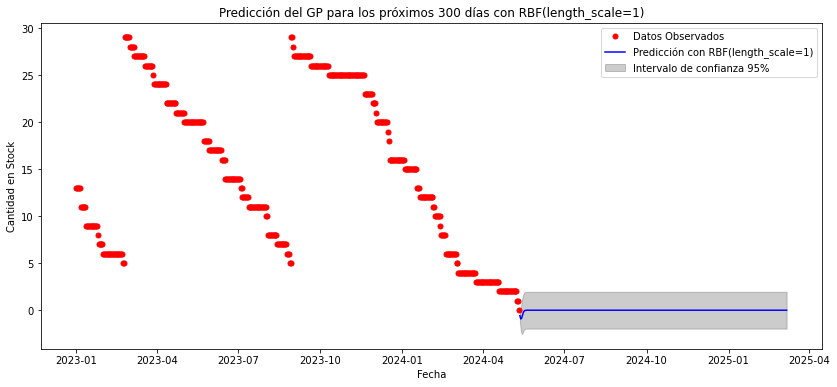

Kernel después de la optimización: RBF(length_scale=2.05)


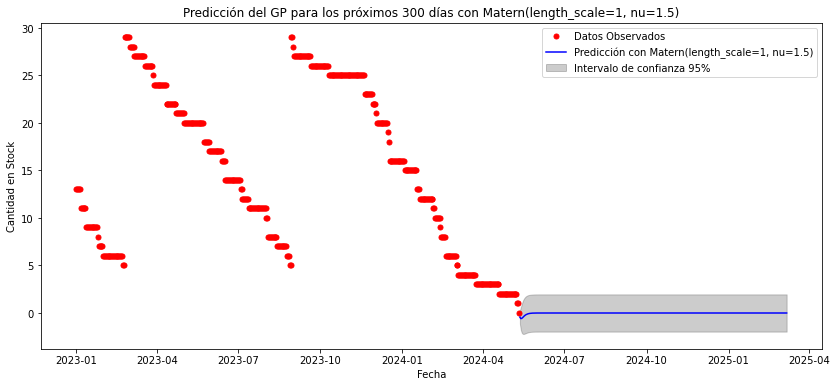

Kernel después de la optimización: Matern(length_scale=3.9, nu=1.5)


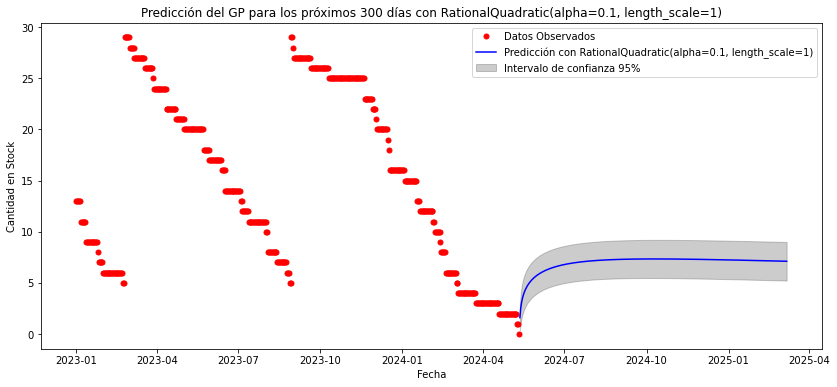

Kernel después de la optimización: RationalQuadratic(alpha=0.155, length_scale=0.874)


/Users/ronaldpoint/opt/anaconda3/envs/data_analysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


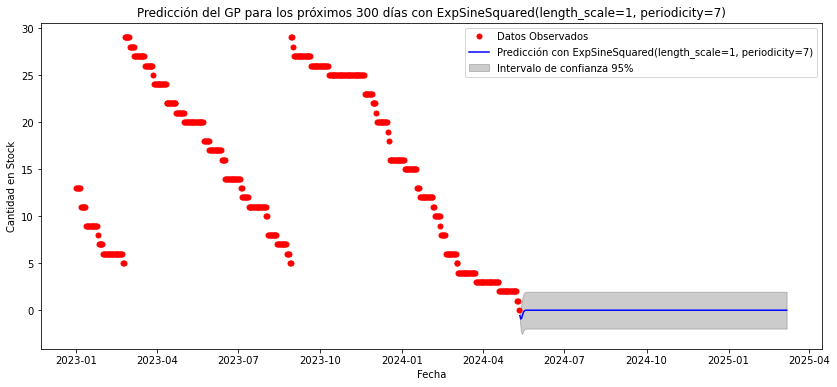

Kernel después de la optimización: ExpSineSquared(length_scale=0.00492, periodicity=2.61e+03)


In [68]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir una función para probar diferentes kernels
def test_gp_with_kernel(producto_daily_data, kernel, n_dias_prediccion):
    # Definir los puntos de entrada (X son los índices de tiempo)
    X = np.arange(len(producto_daily_data)).reshape(-1, 1)
    y = producto_daily_data['StockQTY'].values

    # Crear y entrenar el modelo con el kernel proporcionado
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    gp.fit(X, y)

    # Definir nuevos puntos de predicción para los próximos n_dias_prediccion
    nuevos_dias = np.arange(len(producto_daily_data), len(producto_daily_data) + n_dias_prediccion).reshape(-1, 1)

    # Predicciones
    y_pred_nuevo, sigma_nuevo = gp.predict(nuevos_dias, return_std=True)

    # Crear un rango de fechas extendido para los nuevos días predichos
    fechas_prediccion = pd.date_range(producto_daily_data.index[-1], periods=n_dias_prediccion + 1, freq='D')[1:]

    # Visualización de las predicciones
    plt.figure(figsize=(14, 6))
    plt.plot(producto_daily_data.index, producto_daily_data['StockQTY'], 'r.', markersize=10, label='Datos Observados')
    plt.plot(fechas_prediccion, y_pred_nuevo, 'b-', label=f'Predicción con {kernel}')
    plt.fill_between(fechas_prediccion, y_pred_nuevo - 1.96*sigma_nuevo, y_pred_nuevo + 1.96*sigma_nuevo, 
                     alpha=0.2, color='k', label='Intervalo de confianza 95%')
    plt.title(f'Predicción del GP para los próximos {n_dias_prediccion} días con {kernel}')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad en Stock')
    plt.legend()
    plt.show()

    # Imprimir los parámetros optimizados del kernel
    print(f'Kernel después de la optimización: {gp.kernel_}')

# Definir los kernels a probar
kernels = [
    RBF(length_scale=1.0),  # Kernel RBF
    Matern(length_scale=1.0, nu=1.5),  # Kernel Matern
    RationalQuadratic(length_scale=1.0, alpha=0.1),  # Kernel RationalQuadratic
    ExpSineSquared(length_scale=1.0, periodicity=7.0),  # Kernel periódico (ExpSineSquared)
    # DotProduct()  # Kernel DotProduct
]

# Definir la cantidad de días de predicción
n_dias_prediccion = 300

# Probar cada kernel
for kernel in kernels:
    test_gp_with_kernel(producto_daily_data, kernel, n_dias_prediccion)


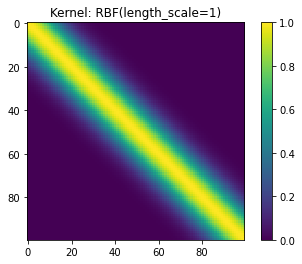

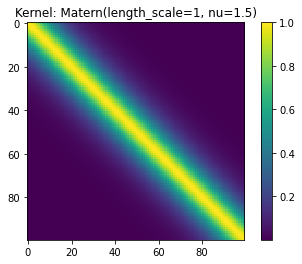

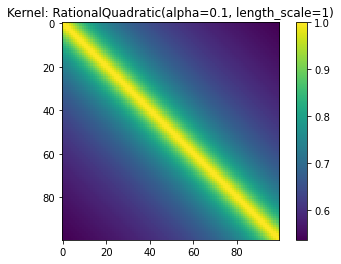

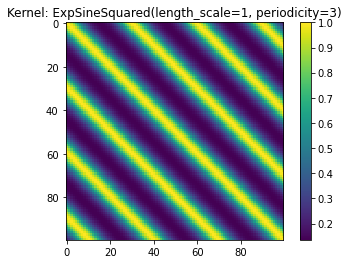

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared

# Definir una función para graficar un kernel
def plot_kernel(kernel, x_range):
    """Función para graficar el kernel en un rango dado"""
    x = np.expand_dims(np.linspace(0, 10, 100), 1)  # Definimos el rango de valores
    K = kernel(x, x)  # Calculamos la matriz de covarianza
    plt.figure(figsize=(6, 4))
    plt.imshow(K, interpolation='nearest', cmap='viridis')
    plt.title(f'Kernel: {kernel}')
    plt.colorbar()
    plt.show()

# Definir el rango de x para visualizar
x_range = np.linspace(0, 10, 100).reshape(-1, 1)

# Definir los kernels
kernels = [
    RBF(length_scale=1.0),  # Kernel RBF
    Matern(length_scale=1.0, nu=1.5),  # Kernel Matern
    RationalQuadratic(length_scale=1.0, alpha=0.1),  # Kernel RationalQuadratic
    ExpSineSquared(length_scale=1.0, periodicity=3.0),  # Kernel periódico (ExpSineSquared)
    # C(1.0, (1e-4, 1e1)) * (RBF(10, (1e-2, 1e2)) + ExpSineSquared(length_scale=1.0, periodicity=10.0)),

]

# Graficar cada kernel
for kernel in kernels:
    plot_kernel(kernel, x_range)
